In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)
    
def flatten(x): return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1,  8, 5, padding=2, stride=2), nn.ReLU(),
        nn.Conv2d( 8, 16, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [1.9780871875, tensor(0.3203)]
valid: [0.732423388671875, tensor(0.7910)]
CPU times: user 5.22 s, sys: 95 ms, total: 5.31 s
Wall time: 1.8 s


## CUDA 

In [15]:
# Somewhat more flexible way
device = torch.device('cuda', 0)

In [16]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self):
        self.run.xb = self.xb.to(self.device)
        self.run.yb = self.yb.to(self.device)

In [17]:
# Somewhat less flexible, but quite convient
torch.cuda.set_device(device)

In [18]:
# export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(),self.yb.cuda()

In [19]:
cbfs.append(CudaCallback)

In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [2.2591321875, tensor(0.1545, device='cuda:0')]
valid: [1.944719140625, tensor(0.2937, device='cuda:0')]
train: [0.970138984375, tensor(0.6889, device='cuda:0')]
valid: [0.245235986328125, tensor(0.9287, device='cuda:0')]
train: [0.21948796875, tensor(0.9329, device='cuda:0')]
valid: [0.16268536376953124, tensor(0.9486, device='cuda:0')]
CPU times: user 4.07 s, sys: 695 ms, total: 4.77 s
Wall time: 4.85 s


### Refactor model 

In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [24]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x): return x.view(((-1,) + size))
    return _inner

In [25]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [26]:
nfs = [8, 16, 32, 32]

In [27]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [28]:
#exort
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [29]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [30]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
run.fit(3, learn)

train: [2.2825475, tensor(0.1645, device='cuda:0')]
valid: [2.13738515625, tensor(0.2127, device='cuda:0')]
train: [1.11871890625, tensor(0.6340, device='cuda:0')]
valid: [0.27969111328125, tensor(0.9213, device='cuda:0')]
train: [0.25898779296875, tensor(0.9240, device='cuda:0')]
valid: [0.2405701904296875, tensor(0.9301, device='cuda:0')]


## Hooks

### Manual insertion 

In [32]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [33]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [34]:
run.fit(2, learn)

train: [1.58603671875, tensor(0.4481, device='cuda:0')]
valid: [0.547429736328125, tensor(0.8302, device='cuda:0')]
train: [0.2219051171875, tensor(0.9311, device='cuda:0')]
valid: [0.150414892578125, tensor(0.9542, device='cuda:0')]


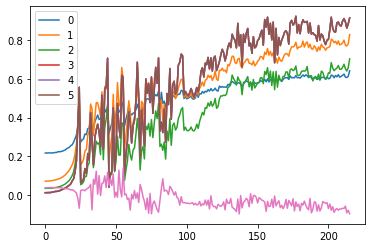

In [35]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6))

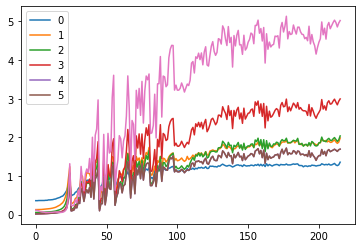

In [36]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

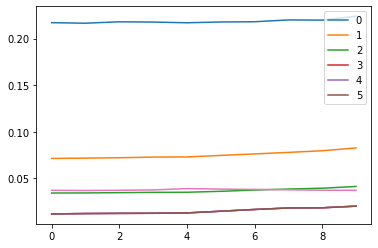

In [37]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

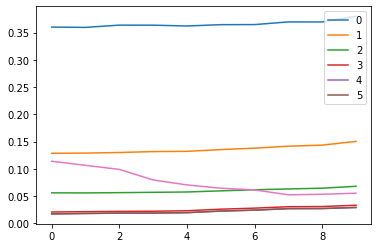

In [38]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

## Pytorch hooks 

In [39]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [40]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [41]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [42]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [43]:
run.fit(1, learn)

train: [1.9184775, tensor(0.3408, device='cuda:0')]
valid: [0.8369125, tensor(0.7448, device='cuda:0')]


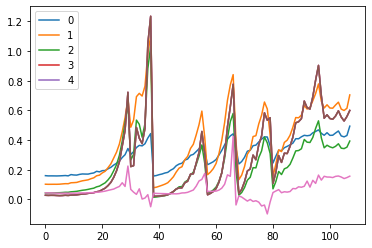

In [44]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

### Hook class 

In [45]:
#export
def children(m): return list(m.children())

class Hook:
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [46]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [47]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [48]:
run.fit(1, learn)

train: [2.04031296875, tensor(0.2896, device='cuda:0')]
valid: [0.9037947265625, tensor(0.6785, device='cuda:0')]


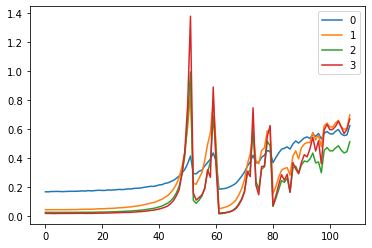

In [49]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))

In [54]:
for nam,val in model.named_children():
    print(val, "next")

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
) next
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
) next
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
) next
Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
) next
AdaptiveAvgPool2d(output_size=1) next
Lambda() next
Linear(in_features=32, out_features=10, bias=True) next


In [55]:
val.d

Linear(in_features=32, out_features=10, bias=True)

In [61]:
for i, (name, val) in enumerate(model.named_children()):
    print(i, name, model[i] == val)

0 0 True
1 1 True
2 2 True
3 3 True
4 4 True
5 5 True
6 6 True


### A Hooks class 

In [70]:
#export
class ListContainer:
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx)==len(self)
            return [o for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1] + '...]'
        return res

In [71]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [72]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [74]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True, False]]

([1, 2], [8])

In [84]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [81]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [85]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f6f0b4b6d90>, <__main__.Hook object at 0x7f6f0b4b6b50>, <__main__.Hook object at 0x7f6f0b4b6d10>, <__main__.Hook object at 0x7f6f0b4b6350>, <__main__.Hook object at 0x7f6f0b4b6650>, <__main__.Hook object at 0x7f6f0b5d7790>, <__main__.Hook object at 0x7f6f0b5d70d0>]

In [86]:
hooks.remove()
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f6f0b4b6d90>, <__main__.Hook object at 0x7f6f0b4b6b50>, <__main__.Hook object at 0x7f6f0b4b6d10>, <__main__.Hook object at 0x7f6f0b4b6350>, <__main__.Hook object at 0x7f6f0b4b6650>, <__main__.Hook object at 0x7f6f0b5d7790>, <__main__.Hook object at 0x7f6f0b5d70d0>]

In [92]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [94]:
x.shape

torch.Size([512, 1, 28, 28])

In [95]:
x.mean(), x.std() # should have normalized values

(tensor(0.0035, device='cuda:0'), tensor(1.0040, device='cuda:0'))

In [117]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.2073, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3497, device='cuda:0', grad_fn=<StdBackward0>))

In [120]:
p.shape

torch.Size([512, 8, 14, 14])

In [121]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [125]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [126]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.5120, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.2013, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.8111109375, tensor(0.3949, device='cuda:0')]
valid: [1.0551572265625, tensor(0.7088, device='cuda:0')]
train: [0.353643984375, tensor(0.8914, device='cuda:0')]
valid: [0.428823779296875, tensor(0.8635, device='cuda:0')]


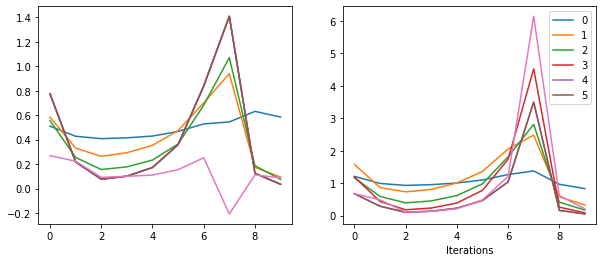

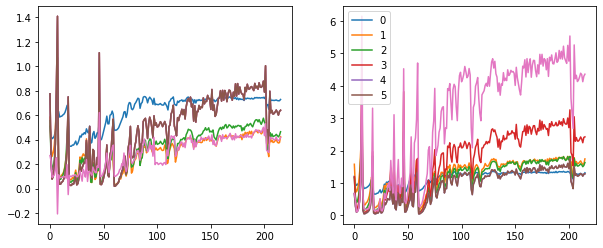

In [127]:
with  Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    plt.xlabel("Iterations")
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Other statistics 

In [134]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, 0, 10)) # 40 bin between 0 and 10

In [135]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [136]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [137]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.4712403125, tensor(0.4861, device='cuda:0')]
valid: [0.608009765625, tensor(0.7981, device='cuda:0')]


In [143]:
torch.stack(hooks[0].stats[2]).shape

torch.Size([108, 40])

In [144]:
torch.stack(hooks[0].stats[2]).t().shape

torch.Size([40, 108])

In [150]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

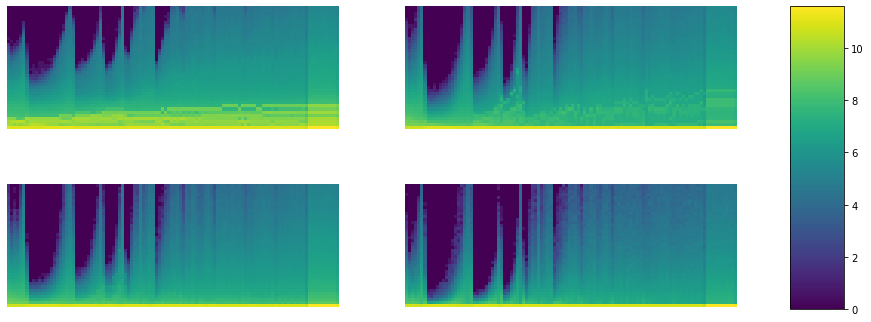

In [151]:
fig, axes = plt.subplots(2,2,figsize=(15,6))
for ax, h, in zip(axes.flatten(), hooks[:4]):
    im = ax.imshow(get_hist(h), origin="lower")
    ax.axis("off")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.tight_layout()

In [152]:
get_hist(h)

tensor([[10.7496, 10.8660, 10.8297,  ..., 11.5976, 11.6010, 11.3348],
        [ 8.4634,  8.4701,  8.5452,  ...,  7.6261,  7.5369,  7.1694],
        [ 8.1851,  7.9913,  8.0919,  ...,  7.4639,  7.3499,  7.0475],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  4.8442,  4.8442,  4.7449],
        [ 0.0000,  0.0000,  0.0000,  ...,  4.8442,  4.7622,  4.4773],
        [ 0.0000,  0.0000,  0.0000,  ...,  4.7274,  4.7791,  4.4998]])

In [153]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

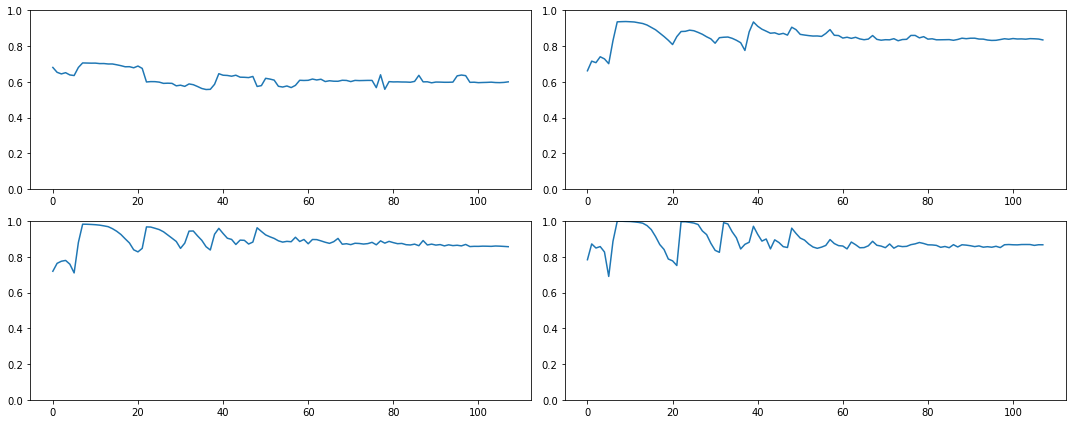

In [154]:
fig, axes = plt.subplots(2,2,figsize=(15,6))
for ax,h, in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

### Generalized ReLU 

In [155]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))
                                                                                                                   
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv    
        
    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
            
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [156]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [157]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5162596875, tensor(0.8372, device='cuda:0')]
valid: [0.1554669677734375, tensor(0.9543, device='cuda:0')]


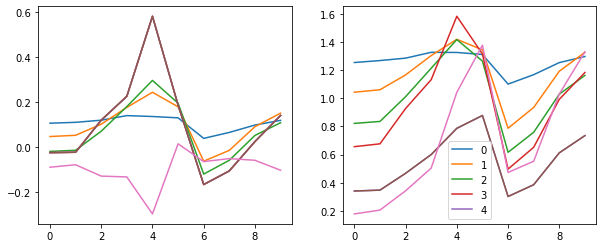

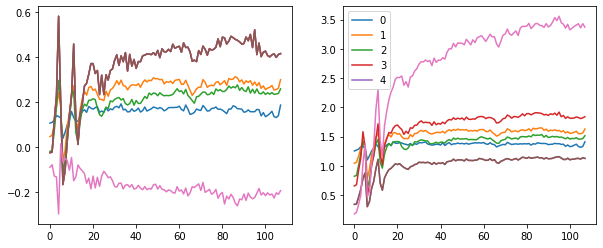

In [158]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

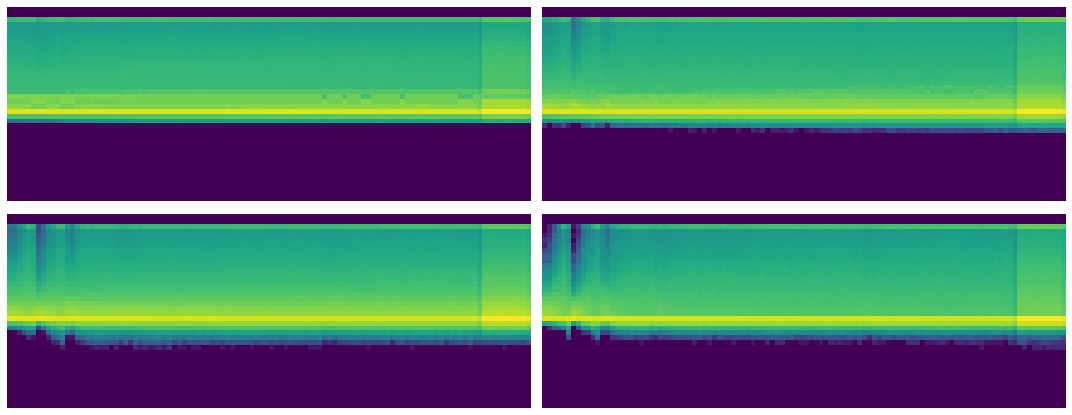

In [159]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [160]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

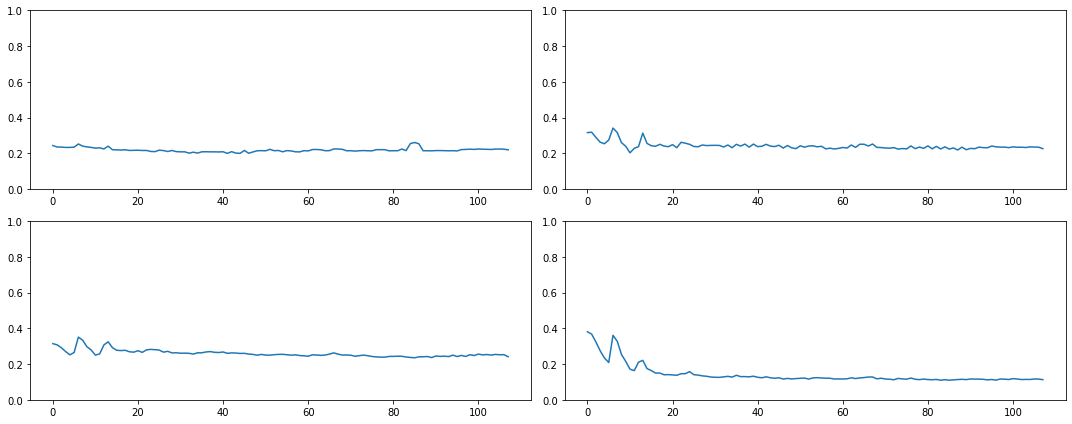

In [161]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [162]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [163]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [164]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [165]:
run.fit(8, learn)

train: [1.06225375, tensor(0.6701, device='cuda:0')]
valid: [0.3040861572265625, tensor(0.9084, device='cuda:0')]
train: [0.37997921875, tensor(0.8836, device='cuda:0')]
valid: [0.25102236328125, tensor(0.9233, device='cuda:0')]
train: [0.17377966796875, tensor(0.9470, device='cuda:0')]
valid: [0.16596005859375, tensor(0.9507, device='cuda:0')]
train: [0.2573159765625, tensor(0.9253, device='cuda:0')]
valid: [0.09953927612304687, tensor(0.9681, device='cuda:0')]
train: [0.093058740234375, tensor(0.9716, device='cuda:0')]
valid: [0.092553076171875, tensor(0.9726, device='cuda:0')]
train: [0.0654024658203125, tensor(0.9792, device='cuda:0')]
valid: [0.06866630249023438, tensor(0.9790, device='cuda:0')]
train: [0.0472601611328125, tensor(0.9856, device='cuda:0')]
valid: [0.062133929443359374, tensor(0.9811, device='cuda:0')]
train: [0.039352265625, tensor(0.9882, device='cuda:0')]
valid: [0.06142908325195313, tensor(0.9818, device='cuda:0')]


In [166]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [169]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [170]:
nb_auto_export()

<IPython.core.display.Javascript object>